In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 25.8 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


# Functions

In [2]:
def create_channel_mappings(media, impressions):
    """
    Generate mapping dictionaries for media spend and impressions columns.

    Parameters:
        media (list of str): List of column names with spend/cost data.
                             Expected to have columns ending with '_cost'.
        impressions (list of str): List of column names with impressions data.
                                   Expected to have columns ending with '_cost_impressions'.

    Returns:
        tuple: Two dictionaries:
            - correct_media_spend_to_channel: Mapping of cost column names to simplified channel names.
            - correct_media_to_channel: Mapping of impressions column names to simplified channel names.
    """
    correct_media_spend_to_channel = {}
    for col in media:
        if col.endswith("_cost"):
            channel_name = col[:-len("_cost")]
        else:
            channel_name = col
        correct_media_spend_to_channel[col] = channel_name

    correct_media_to_channel = {}
    for col in impressions:
        if col.endswith("_impressions"):
          #substitute
            channel_name = col[:-len("_impressions")]
        else:
            channel_name = col
        correct_media_to_channel[col] = channel_name

    return correct_media_spend_to_channel, correct_media_to_channel

# Raw DAta

In [3]:
# Assuming your CSV file is in the 'MyDrive' folder
#file_path = '/content/drive/MyDrive/mmm_train_all.csv'
file_path = 'mmm_train_all.csv'
# Read the CSV file into a pandas DataFrame
raw_data = pd.read_csv(file_path)

In [4]:
print(raw_data.shape)
raw_data = raw_data.drop_duplicates()
print(raw_data.shape)

(335, 32)
(335, 32)


In [5]:
# Assuming your DataFrame has a date column called 'date'
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Find gaps larger than 1 day
df['date_diff'] = df['date'].diff().dt.days
non_sequential = df[df['date_diff'] > 1]
print(non_sequential)

Empty DataFrame
Columns: [Unnamed: 0, model_week, date, iso_week, iso_year, ga4_sessions, podcast_streams, linkedin_spend, linkedin_impressions, linkedin_clicks, gSearch_sessions, gSearch_impressions, gift_spend, email_sent_cnt, email_delivered_cnt, email_opened_cnt, direct_spend, fb_spend, fb_impressions, fb_clicks, googleAds_spend, googleAds_impressions, event_spend, mql_count, impactDotCom_ga4_sessions, month, daily_avg_queries, inflation_rate, durable_goods_rates, consumer_sentiment_index, averageMQL, smoothed_MQL, date_diff]
Index: []

[0 rows x 33 columns]


In [6]:
raw_data.columns

Index(['Unnamed: 0', 'model_week', 'date', 'iso_week', 'iso_year',
       'ga4_sessions', 'podcast_streams', 'linkedin_spend',
       'linkedin_impressions', 'linkedin_clicks', 'gSearch_sessions',
       'gSearch_impressions', 'gift_spend', 'email_sent_cnt',
       'email_delivered_cnt', 'email_opened_cnt', 'direct_spend', 'fb_spend',
       'fb_impressions', 'fb_clicks', 'googleAds_spend',
       'googleAds_impressions', 'event_spend', 'mql_count',
       'impactDotCom_ga4_sessions', 'month', 'daily_avg_queries',
       'inflation_rate', 'durable_goods_rates', 'consumer_sentiment_index',
       'averageMQL', 'smoothed_MQL'],
      dtype='object')

# Baseline  Model

In [7]:
data = raw_data[['date', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions',
        'gift_spend', 'email_opened_cnt', 'direct_spend',
       'fb_spend','googleAds_spend','event_spend', 'mql_count',
       'impactDotCom_ga4_sessions',  'daily_avg_queries', 'smoothed_MQL',  'daily_avg_queries',
       'inflation_rate','durable_goods_rates']].copy()
data['mql_count'] = data['mql_count'].fillna(0)
data['smoothed_MQL'] = data['smoothed_MQL'].fillna(0)
data['revenueProxy'] = data['smoothed_MQL'] * 1000

In [8]:
# STEP 2: LOAD AND PREPARE YOUR DATA

# Replace 'my_data.csv' with the path to your actual dataset
# data = pd.read_csv('/Users/gabriele/Downloads/dataset-ms - dataset-ms.csv')

# # Identify columns that contain spend-related keywords (e.g., 'spend', 'cost', 'budget')
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = ['podcast_streams', 'email_opened_cnt', 'impactDotCom_ga4_sessions']

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# # Identify the output (revenue) column(s)
# output = [
#     col for col in data.columns
#     if 'revenue' in col.lower()
# ]

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenueproxy' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

Selected Media Channels: ['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend']


,date,podcast_streams,linkedin_spend,gSearch_sessions,gift_spend,email_opened_cnt,direct_spend,fb_spend,googleAds_spend,event_spend,mql_count,impactDotCom_ga4_sessions,daily_avg_queries,smoothed_MQL,daily_avg_queries,inflation_rate,durable_goods_rates,revenueProxy,date_week,t
0,2024-04-11,332.0,11063.50,1324.0,0.00,0.0,9000.0,2169.57,6448.16,0.0,61,4972.0,16753.0,61.0,16753.0,0.0336,0.0022,61000.0,2024-04-11,0
1,2024-04-12,227.0,10985.40,1127.0,498.86,0.0,0.0,2189.92,4544.18,0.0,60,4538.0,16753.0,60.0,16753.0,0.0336,0.0022,60000.0,2024-04-12,1
2,2024-04-13,186.0,8826.29,504.0,0.00,0.0,0.0,2140.88,1676.13,0.0,21,2430.0,16753.0,21.0,16753.0,0.0336,0.0022,21000.0,2024-04-13,2
3,2024-04-14,120.0,7257.84,519.0,0.00,0.0,0.0,2404.75,2054.01,0.0,30,2546.0,16753.0,30.0,16753.0,0.0336,0.0022,30000.0,2024-04-14,3
4,2024-04-15,182.0,10275.43,1133.0,339.42,0.0,0.0,2307.37,5510.42,0.0,116,7164.0,16753.0,116.0,16753.0,0.0336,0.0022,116000.0,2024-04-15,4


******** Spend Share Analysis ********
     Media_Channel  Spend_Share
0   linkedin_spend     0.510996
1       gift_spend     0.011892
2     direct_spend     0.142351
3         fb_spend     0.090379
4  googleAds_spend     0.208683
5      event_spend     0.035698


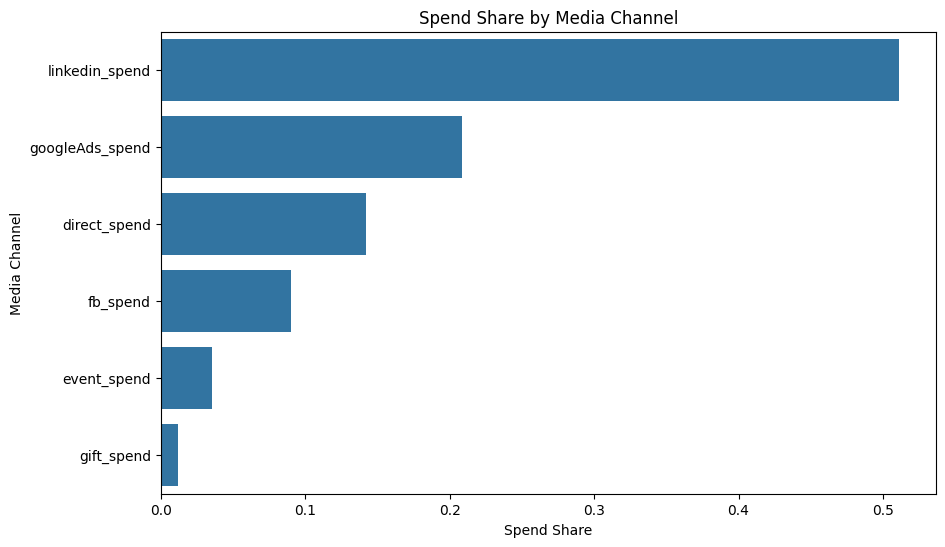


******** Correlation Analysis ********
Using revenue column: revenueProxy
Correlation of inputs with revenueProxy:
smoothed_MQL                 1.000000
mql_count                    0.750506
googleAds_spend              0.666414
gSearch_sessions             0.661128
impactDotCom_ga4_sessions    0.508956
linkedin_spend               0.316913
gift_spend                   0.297370
fb_spend                     0.168615
daily_avg_queries            0.097341
daily_avg_queries            0.097341
event_spend                  0.095848
email_opened_cnt             0.072799
podcast_streams              0.057639
direct_spend                 0.021080
durable_goods_rates         -0.012023
inflation_rate              -0.016332
t                           -0.159613
Name: revenueProxy, dtype: float64


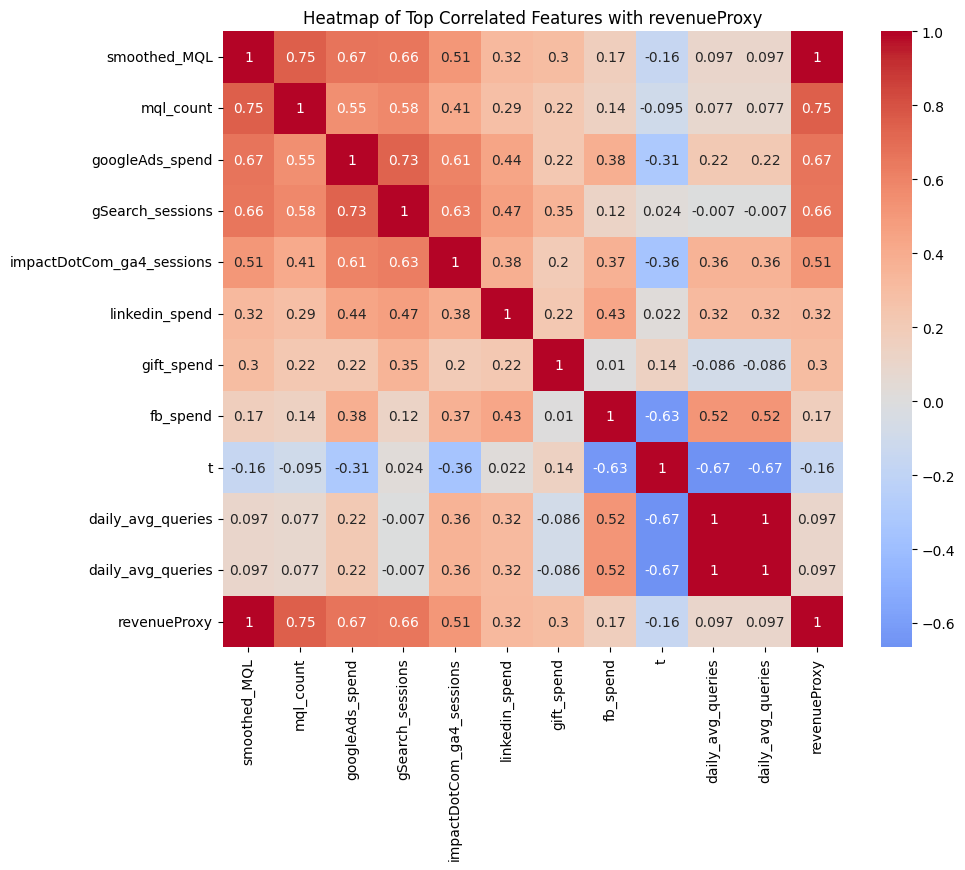


******** Multicollinearity Analysis ********
                      Feature         VIF
13          daily_avg_queries         inf
11          daily_avg_queries         inf
14             inflation_rate  123.937365
1              linkedin_spend   40.492780
2            gSearch_sessions   39.727924
10  impactDotCom_ga4_sessions   22.371760
7             googleAds_spend   21.799469
6                    fb_spend   20.884947
12               smoothed_MQL   14.634332
16                          t    8.385511
9                   mql_count    7.503751
3                  gift_spend    1.565662
0             podcast_streams    1.365589
15        durable_goods_rates    1.303569
4            email_opened_cnt    1.153211
5                direct_spend    1.065221
8                 event_spend    1.049062

******** Variables with Less Than 15 Records ********


/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [9]:
# Import necessary libraries for visualization and multicollinearity analysis.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor


# ----------------------------
# 1. Spend Share Analysis
# ----------------------------
print("******** Spend Share Analysis ********")
if media:
    # Calculate total spend across all identified media channels.
    total_media_spend = data[media].sum().sum()
    # Compute spend share for each media channel.
    spend_share = data[media].sum() / total_media_spend
    spend_share_df = spend_share.reset_index()
    spend_share_df.columns = ['Media_Channel', 'Spend_Share']
    print(spend_share_df)

    # Plot a bar chart of spend share.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Spend_Share', y='Media_Channel',
                data=spend_share_df.sort_values(by='Spend_Share', ascending=False))
    plt.title("Spend Share by Media Channel")
    plt.xlabel("Spend Share")
    plt.ylabel("Media Channel")
    plt.show()
else:
    print("No media channels available for spend share analysis.")


# ----------------------------
# 2. Correlation Analysis between Inputs and Output (ecommerce_revenue)
# ----------------------------
print("\n******** Correlation Analysis ********")
# Determine the revenue column (assume that output[0] is the revenue column, as set previously)
revenue_col = output[0] if output and output[0] in data.columns else 'ecommerce_revenue'
print("Using revenue column:", revenue_col)

# Select only numeric features from the complete dataset.
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

if revenue_col in corr_matrix.columns:
    # Calculate correlation of all numeric features with the revenue column.
    corr_with_rev = corr_matrix[revenue_col].drop(labels=[revenue_col]).sort_values(ascending=False)
    print("Correlation of inputs with {}:".format(revenue_col))
    print(corr_with_rev)

    # Identify top 10 features most correlated (by absolute value) with the revenue.
    top_features = corr_with_rev.abs().sort_values(ascending=False).head(10).index.tolist() + [revenue_col]

    # Plot a heatmap displaying correlations among these top features.
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data[top_features].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title("Heatmap of Top Correlated Features with {}".format(revenue_col))
    plt.show()
else:
    print("Revenue column not found in the correlation matrix.")


# ----------------------------
# 3. Multicollinearity Analysis (Variance Inflation Factor)
# ----------------------------
print("\n******** Multicollinearity Analysis ********")
# Use the feature set X defined earlier; select only numeric columns.
X_numeric = X.select_dtypes(include=[np.number])
if not X_numeric.empty:
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X_numeric.columns
    # Calculate VIF for each feature.
    vif_df["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                    for i in range(X_numeric.shape[1])]
    print(vif_df.sort_values(by="VIF", ascending=False))
else:
    print("No numeric features available in X for multicollinearity analysis.")


# ----------------------------
# 4. Check for Variables with Less Than 15 Records
# ----------------------------
print("\n******** Variables with Less Than 15 Records ********")
low_record_columns = {col: data[col].count() for col in data.columns if data[col].count() < 15}
if low_record_columns:
    for col, cnt in low_record_columns.items():
        print(f"Column '{col}' has only {cnt} recorded non-null entries.")
else:
    print("All variables have at least 15 records.")


In [10]:
cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

Cost Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}
Impressions Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}


In [11]:
# def create_seasonality_features(data: pd.DataFrame, date_column: str, output_variable: str, yearly_seasonality: int) -> pd.DataFrame:
#     """
#     Creates seasonality effect features for modeling based on the yearly seasonality using the statsmodels library.

#     Parameters:
#     - data (pd.DataFrame): The input dataframe.
#     - date_column (str): The name of the date column.
#     - output_variable (str): The name of the output variable.
#     - yearly_seasonality (int): The yearly seasonality period (e.g., 52 for weekly, 365 for daily).

#     Returns:
#     - pd.DataFrame: The dataframe with added seasonality features.
#     """
#     from statsmodels.tsa.seasonal import seasonal_decompose

#     # Ensure the date column is in datetime format
#     data[date_column] = pd.to_datetime(data[date_column])

#     # Sort the data by date
#     data = data.sort_values(by=date_column)

#     # Set the date column as index for seasonal decomposition
#     data.set_index(date_column, inplace=True)

#     # Perform seasonal decomposition with multiplicative model
#     decomposition = seasonal_decompose(data[output_variable], model='multiplicative', period=yearly_seasonality)

#     # # Add seasonal component as a feature
#     data[f'seasonal_{output_variable}'] = decomposition.seasonal
#     # data[f'seasonal_{output_variable}'] = 1

#     # Reset index to retain the date column
#     data.reset_index(inplace=True)

#     return data

# # Example usage
# data = create_seasonality_features(
#     data,
#     date_column='date_week',
#     output_variable='mql_count',
#     yearly_seasonality=52
# )

# data.head()

## Models

In [12]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenueProxy',   # make sure this matches your KPI column in the DataFrame
    controls=['gSearch_sessions'],  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/data/load.py:1033: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/data/load.py:206: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will be reset to [1]
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/data/input_data.py:463: UserWarning: Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.
  warnings.warn(


In [17]:
data_meridian.as_dataset()

<xarray.Dataset> Size: 54kB
Dimensions:                (time: 335, geo: 1, control_variable: 1,
                            media_time: 335, media_channel: 6,
                            organic_media_channel: 3)
Coordinates:
  * time                   (time) object 3kB '2024-04-11' ... '2025-03-11'
  * geo                    (geo) <U12 48B 'national_geo'
  * control_variable       (control_variable) object 8B 'gSearch_sessions'
  * media_time             (media_time) object 3kB '2024-04-11' ... '2025-03-11'
  * media_channel          (media_channel) <U15 360B 'linkedin_spend' ... 'ev...
  * organic_media_channel  (organic_media_channel) object 24B 'podcast_stream...
Data variables:
    kpi                    (geo, time) float64 3kB 6.1e+04 6e+04 ... 2.7e+04
    population             (geo) float64 8B 1.0
    controls               (geo, time, control_variable) float64 3kB 1.324e+0...
    revenue_per_kpi        (geo, time) float64 3kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    media                  (geo, media_time, media_channel) float64 16kB 1.10...
    media_spend            (geo, time, media_channel) float64 16kB 1.106e+04 ...
    organic_media          (geo, media_time, organic_media_channel) float64 8kB ...

In [18]:
build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=(0.30, 0.3),
  gift_spend=(0.01, 0.4),
  direct_spend=(0.01, 0.4),
  fb_spend=(0.10, 0.3),
  googleAds_spend=(0.10, 0.25),
  event_spend=(0.01, 0.1),
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=5)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/model/model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


In [24]:
mmm.sample_prior(100000)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

W0000 00:00:1751559861.511874 90046030 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


Runtime: 108.8460 seconds


['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend']
[(0.3, 0.3), (0.01, 0.4), (0.01, 0.4), (0.1, 0.3), (0.1, 0.25), (0.01, 0.1)]


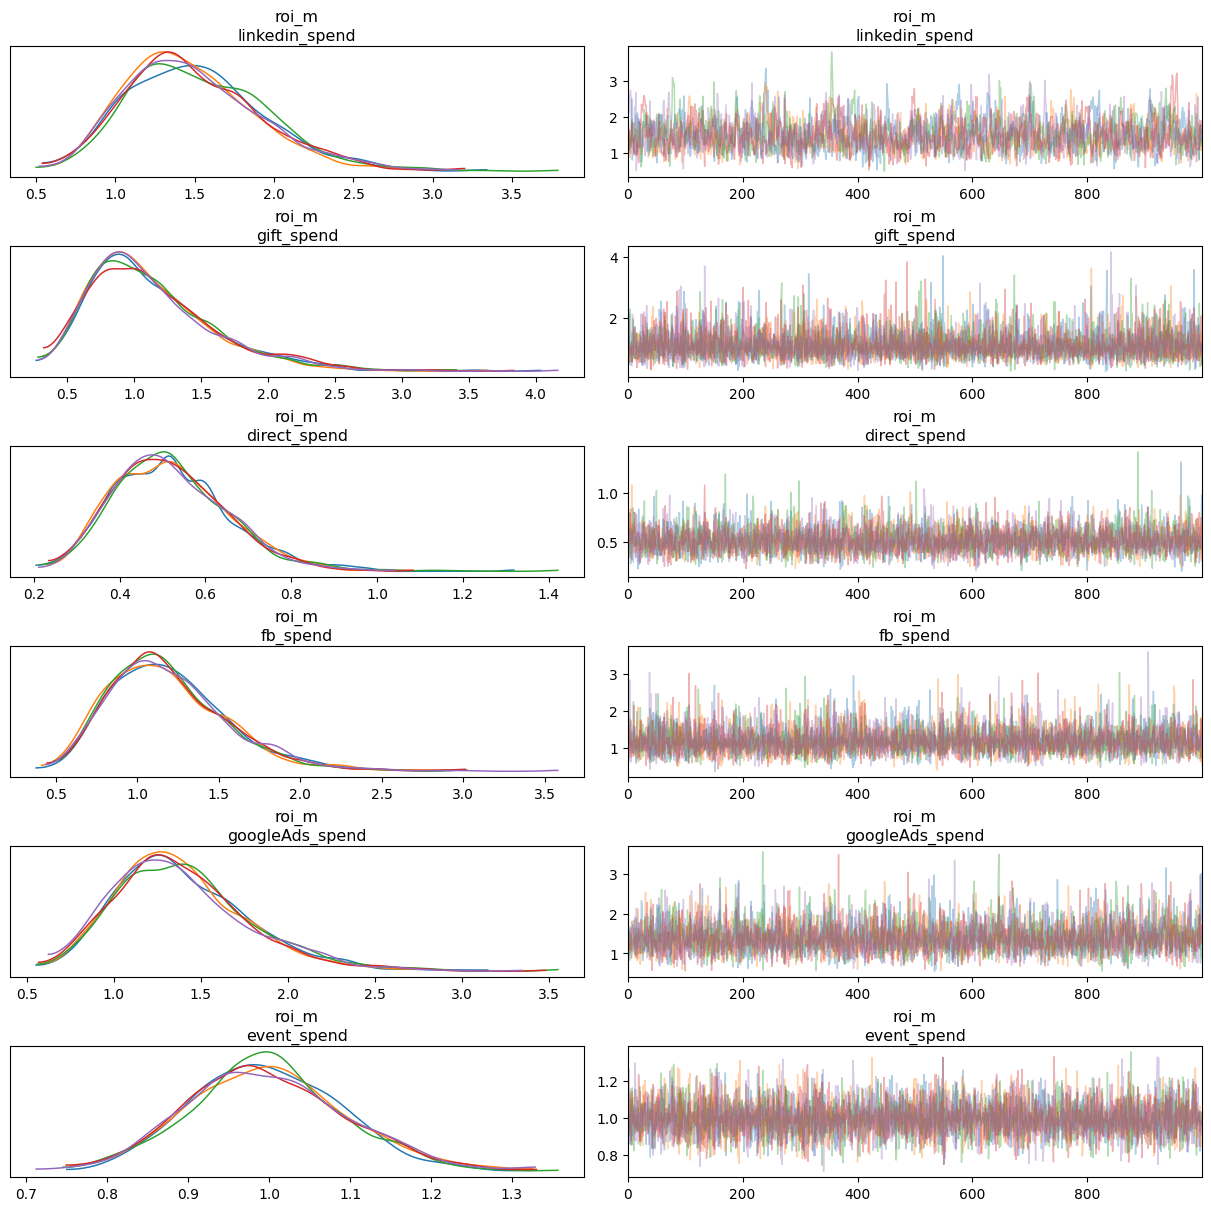

In [25]:
print(['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend',
       'googleAds_spend', 'event_spend'])
print(roi_m)
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )


In [26]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

In [32]:
mmm

In [27]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()


/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:556: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

In [28]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:556: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


,metric,geo_granularity,value
0,R_Squared,national,0.520737
1,MAPE,national,0.287657
2,wMAPE,national,0.262700


In [29]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.summary_table()

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:855: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/visualizer.py:1619: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,linkedin_spend,prior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$5,423,428 ($3,158,288, $8,513,596)","19.8% (11.5%, 31.1%)","1.4 (0.8, 2.2)","1.41 (0.82, 2.22)","0.7 (0.2, 1.2)","$0.7 ($0.5, $1.2)"
1,linkedin_spend,posterior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$5,763,736 ($3,424,827, $8,746,101)","33.5% (19.9%, 50.9%)","1.5 (0.9, 2.3)","1.50 (0.89, 2.28)","0.8 (0.3, 1.3)","$0.7 ($0.4, $1.1)"
2,gift_spend,prior,"89,413",1%,"$89,413",1%,"$1,000","$97,841 ($46,908, $174,472)","0.4% (0.2%, 0.6%)","1.1 (0.5, 2.0)","1.09 (0.52, 1.95)","0.5 (0.2, 1.0)","$1.0 ($0.5, $1.9)"
3,gift_spend,posterior,"89,413",1%,"$89,413",1%,"$1,000","$101,688 ($47,831, $187,067)","0.6% (0.3%, 1.1%)","1.1 (0.5, 2.1)","1.14 (0.53, 2.09)","0.5 (0.2, 1.0)","$1.0 ($0.5, $1.9)"
4,direct_spend,prior,"1,070,271",14%,"$1,070,271",14%,"$1,000","$1,172,837 ($559,769, $2,087,079)","4.3% (2.0%, 7.6%)","1.1 (0.5, 2.0)","1.10 (0.52, 1.95)","0.6 (0.2, 1.1)","$1.0 ($0.5, $1.9)"
5,direct_spend,posterior,"1,070,271",14%,"$1,070,271",14%,"$1,000","$556,468 ($351,920, $806,749)","3.2% (2.0%, 4.7%)","0.5 (0.3, 0.8)","0.52 (0.33, 0.75)","0.2 (0.1, 0.4)","$2.0 ($1.3, $3.0)"
6,fb_spend,prior,"679,517",9%,"$679,517",9%,"$1,000","$786,410 ($458,642, $1,232,695)","2.9% (1.7%, 4.5%)","1.2 (0.7, 1.8)","1.16 (0.67, 1.81)","0.5 (0.2, 1.0)","$0.9 ($0.6, $1.5)"
7,fb_spend,posterior,"679,517",9%,"$679,517",9%,"$1,000","$812,237 ($472,643, $1,269,632)","4.7% (2.7%, 7.4%)","1.2 (0.7, 1.9)","1.20 (0.70, 1.87)","0.6 (0.2, 1.0)","$0.9 ($0.5, $1.4)"
8,googleAds_spend,prior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$1,789,071 ($1,148,710, $2,613,536)","6.5% (4.2%, 9.5%)","1.1 (0.7, 1.7)","1.14 (0.73, 1.67)","0.5 (0.2, 0.9)","$0.9 ($0.6, $1.4)"
9,googleAds_spend,posterior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$2,186,564 ($1,334,320, $3,300,929)","12.7% (7.8%, 19.2%)","1.4 (0.9, 2.1)","1.39 (0.85, 2.10)","0.8 (0.4, 1.3)","$0.7 ($0.5, $1.2)"


In [30]:

# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

alt.LayerChart(...)

In [31]:
media_summary.plot_contribution_pie_chart()


alt.LayerChart(...)

In [35]:
media_summary.plot_spend_vs_contribution()


alt.FacetChart(...)

In [36]:
media_summary.plot_roi_vs_effectiveness()

alt.Chart(...)

In [37]:
media_summary.plot_roi_vs_mroi()

alt.Chart(...)

In [38]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves()

alt.FacetChart(...)

In [39]:
media_effects.plot_adstock_decay()

alt.FacetChart(...)

In [40]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.summary_table()

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:855: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/visualizer.py:1619: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,linkedin_spend,prior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$5,636,146 ($3,204,361, $8,905,619)","20.5% (11.6%, 32.4%)","1.5 (0.8, 2.3)","1.47 (0.83, 2.32)","0.7 (0.3, 1.3)","$0.7 ($0.4, $1.2)"
1,linkedin_spend,posterior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$4,936,928 ($3,001,368, $7,395,040)","28.7% (17.5%, 43.0%)","1.3 (0.8, 1.9)","1.29 (0.78, 1.92)","0.5 (0.2, 0.9)","$0.8 ($0.5, $1.3)"
2,gift_spend,prior,"89,413",1%,"$89,413",1%,"$1,000","$97,921 ($48,881, $172,326)","0.4% (0.2%, 0.6%)","1.1 (0.5, 1.9)","1.10 (0.55, 1.93)","0.5 (0.2, 1.0)","$1.0 ($0.5, $1.8)"
3,gift_spend,posterior,"89,413",1%,"$89,413",1%,"$1,000","$102,127 ($46,797, $186,169)","0.6% (0.3%, 1.1%)","1.1 (0.5, 2.1)","1.14 (0.52, 2.08)","0.5 (0.2, 1.0)","$1.0 ($0.5, $1.9)"
4,direct_spend,prior,"1,070,271",14%,"$1,070,271",14%,"$1,000","$1,176,556 ($527,505, $2,120,362)","4.3% (1.9%, 7.7%)","1.1 (0.5, 2.0)","1.10 (0.49, 1.98)","0.6 (0.2, 1.2)","$1.0 ($0.5, $2.0)"
5,direct_spend,posterior,"1,070,271",14%,"$1,070,271",14%,"$1,000","$505,647 ($317,318, $733,363)","2.9% (1.8%, 4.3%)","0.5 (0.3, 0.7)","0.47 (0.30, 0.69)","0.2 (0.1, 0.3)","$2.2 ($1.5, $3.4)"
6,fb_spend,prior,"679,517",9%,"$679,517",9%,"$1,000","$805,144 ($467,466, $1,284,041)","2.9% (1.7%, 4.7%)","1.2 (0.7, 1.9)","1.18 (0.69, 1.89)","0.6 (0.2, 1.1)","$0.9 ($0.5, $1.5)"
7,fb_spend,posterior,"679,517",9%,"$679,517",9%,"$1,000","$787,388 ($465,819, $1,216,556)","4.6% (2.7%, 7.1%)","1.2 (0.7, 1.8)","1.16 (0.69, 1.79)","0.5 (0.2, 1.0)","$0.9 ($0.6, $1.5)"
8,googleAds_spend,prior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$1,805,970 ($1,141,648, $2,669,237)","6.6% (4.2%, 9.7%)","1.2 (0.7, 1.7)","1.15 (0.73, 1.70)","0.6 (0.2, 0.9)","$0.9 ($0.6, $1.4)"
9,googleAds_spend,posterior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$2,068,444 ($1,291,302, $3,091,433)","12.0% (7.5%, 18.0%)","1.3 (0.8, 2.0)","1.32 (0.82, 1.97)","0.7 (0.3, 1.2)","$0.8 ($0.5, $1.2)"


In [42]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves(
    plot_separately=False,
    include_ci=False
)

alt.LayerChart(...)

# Baseline  EOY